Loading data and computing Tail Wasserstein distances...
  Loaded ssp126
  Loaded ssp245
  Loaded ssp585
  Loaded g6sulfur

Pooling Wasserstein distances across all scenarios and models...

Percentile cutpoints:
  P25 = 0.2742
  P75 = 1.6357
  P90 = 3.2795


/tmp/ipykernel_75477/2502337787.py:232: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.05, 1.0, 1.0], h_pad=1.0, w_pad=0.5)


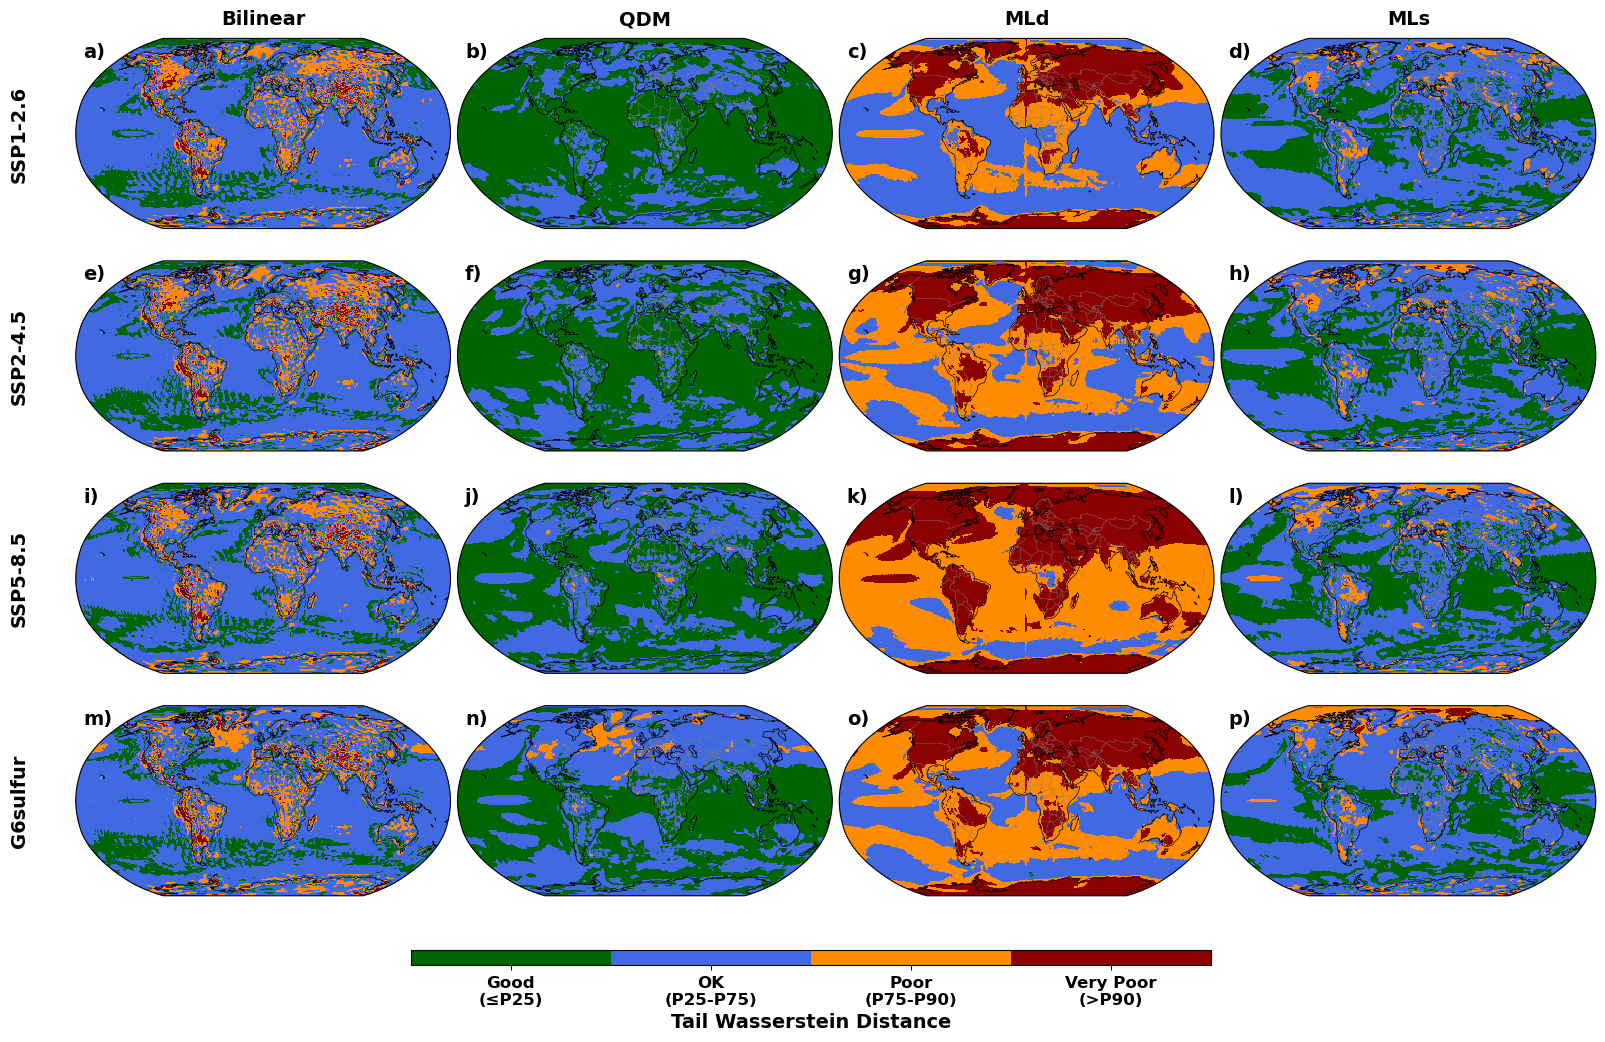

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap, BoundaryNorm

# ----------------------------
# Configuration
# ----------------------------
results_dir = Path("../evaluation_results")
results_residual_dir = Path("../evaluation_results_residual")
figures_dir = Path("../Figures")

var_name = 'tas'
scenarios = ['ssp126', 'ssp245', 'ssp585', 'g6sulfur']
scenario_labels = {
    'ssp126': 'SSP1-2.6',
    'ssp245': 'SSP2-4.5',
    'ssp585': 'SSP5-8.5',
    'g6sulfur': 'G6sulfur'
}

# Model configuration
models = ['bilinear', 'qdm', 'mld', 'mls']
model_labels = {
    'bilinear': 'Bilinear',
    'qdm': 'QDM',
    'mld': 'MLd',
    'mls': 'MLs'
}

# Tail threshold
q_threshold = 0.90

# ----------------------------
# Functions
# ----------------------------
def compute_tail_wasserstein(pred_timeseries, truth_timeseries, q_threshold=0.90, n_quantiles=50):
    """Compute Tail Wasserstein-1 distance for a single time series."""
    pred_clean = pred_timeseries[~np.isnan(pred_timeseries)]
    truth_clean = truth_timeseries[~np.isnan(truth_timeseries)]
    
    if len(pred_clean) < 10 or len(truth_clean) < 10:
        return np.nan
    
    p_levels = np.linspace(q_threshold, 1.0, n_quantiles)
    q_pred = np.quantile(pred_clean, p_levels)
    q_truth = np.quantile(truth_clean, p_levels)
    abs_diff = np.abs(q_pred - q_truth)
    wasserstein_distance = np.trapz(abs_diff, p_levels)
    wasserstein_distance /= (1.0 - q_threshold)
    
    return wasserstein_distance

def compute_spatial_tail_wasserstein(pred_data, truth_data, q_threshold=0.90):
    """Compute Tail Wasserstein-1 distance for each grid point."""
    n_time, n_lat, n_lon = pred_data.shape
    wasserstein_map = np.zeros((n_lat, n_lon))
    
    for i in range(n_lat):
        for j in range(n_lon):
            pred_ts = pred_data[:, i, j]
            truth_ts = truth_data[:, i, j]
            wasserstein_map[i, j] = compute_tail_wasserstein(
                pred_ts, truth_ts, q_threshold=q_threshold
            )
    
    return wasserstein_map

def categorize_wasserstein(w_map, p25, p75, p90):
    """Categorize Wasserstein distances into performance bins."""
    categories = np.full_like(w_map, np.nan)
    valid_mask = ~np.isnan(w_map)
    
    categories[valid_mask & (w_map <= p25)] = 0  # Good (≤P25)
    categories[valid_mask & (w_map > p25) & (w_map <= p75)] = 1  # OK
    categories[valid_mask & (w_map > p75) & (w_map <= p90)] = 2  # Poor
    categories[valid_mask & (w_map > p90)] = 3  # Very poor
    
    return categories

# ----------------------------
# Load data and calculate Wasserstein distances
# ----------------------------
print("Loading data and computing Tail Wasserstein distances...")
wasserstein_maps = {scenario: {} for scenario in scenarios}
lat, lon = None, None

for scenario in scenarios:
    # Load main results (for groundtruth, bilinear, MLd)
    main_file = results_dir / f"{var_name}_evaluation_{scenario}.nc"
    ds_main = xr.open_dataset(main_file)
    
    truth = ds_main['groundtruth'].values
    
    if lat is None:
        lat = ds_main.lat.values
        lon = ds_main.lon.values
    
    # Bilinear Wasserstein
    if 'input' in ds_main:
        wasserstein_maps[scenario]['bilinear'] = compute_spatial_tail_wasserstein(
            ds_main['input'].values, truth, q_threshold=q_threshold
        )
    
    # MLd Wasserstein (zscore_pixel)
    if 'pred_zscore_pixel' in ds_main:
        wasserstein_maps[scenario]['mld'] = compute_spatial_tail_wasserstein(
            ds_main['pred_zscore_pixel'].values, truth, q_threshold=q_threshold
        )
    
    # Load QDM results
    qdm_file = results_dir / f"{var_name}_evaluation_{scenario}_qdm.nc"
    if qdm_file.exists():
        ds_qdm = xr.open_dataset(qdm_file)
        if 'pred_qdm' in ds_qdm:
            wasserstein_maps[scenario]['qdm'] = compute_spatial_tail_wasserstein(
                ds_qdm['pred_qdm'].values, truth, q_threshold=q_threshold
            )
    
    # Load residual results (for MLs)
    residual_file = results_residual_dir / f"{var_name}_evaluation_{scenario}.nc"
    if residual_file.exists():
        ds_residual = xr.open_dataset(residual_file)
        if 'pred_grid' in ds_residual:
            wasserstein_maps[scenario]['mls'] = compute_spatial_tail_wasserstein(
                ds_residual['pred_grid'].values, truth, q_threshold=q_threshold
            )
    
    print(f"  Loaded {scenario}")

# ----------------------------
# Compute global percentiles across all scenarios and models
# ----------------------------
print("\nPooling Wasserstein distances across all scenarios and models...")
all_values = []
for scenario in scenarios:
    for model in models:
        if model in wasserstein_maps[scenario]:
            valid = wasserstein_maps[scenario][model][~np.isnan(wasserstein_maps[scenario][model])]
            all_values.extend(valid)

all_values = np.array(all_values)

# Compute percentile cutpoints
p25 = np.percentile(all_values, 25)
p75 = np.percentile(all_values, 75)
p90 = np.percentile(all_values, 90)

print(f"\nPercentile cutpoints:")
print(f"  P25 = {p25:.4f}")
print(f"  P75 = {p75:.4f}")
print(f"  P90 = {p90:.4f}")

# ----------------------------
# Categorize all maps
# ----------------------------
categorical_maps = {scenario: {} for scenario in scenarios}
for scenario in scenarios:
    for model in models:
        if model in wasserstein_maps[scenario]:
            categorical_maps[scenario][model] = categorize_wasserstein(
                wasserstein_maps[scenario][model], p25, p75, p90
            )

# ----------------------------
# Create 4x4 subplot figure
# ----------------------------
fig = plt.figure(figsize=(16, 10))

# Define colors: Good (dark green), OK (blue), Poor (orange), Very poor (dark red)
colors = ['#006400', '#4169E1', '#FF8C00', '#8B0000']
cmap = ListedColormap(colors)
bounds = [-0.5, 0.5, 1.5, 2.5, 3.5]
norm = BoundaryNorm(bounds, cmap.N)

# Panel labels
panel_labels = [f"{chr(97 + i)})" for i in range(16)]

# Create meshgrid for plotting
lon_2d, lat_2d = np.meshgrid(lon, lat)

# Plot 4 rows (scenarios) x 4 columns (models)
for row_idx, scenario in enumerate(scenarios):
    for col_idx, model in enumerate(models):
        ax = fig.add_subplot(4, 4, row_idx * 4 + col_idx + 1, projection=ccrs.Robinson())
        
        cat_map = categorical_maps[scenario][model]
        
        im = ax.pcolormesh(lon_2d, lat_2d, cat_map,
                          transform=ccrs.PlateCarree(),
                          cmap=cmap, norm=norm,
                          shading='auto')
        
        ax.coastlines(linewidth=0.5, color='black')
        ax.add_feature(cfeature.BORDERS, linewidth=0.3, edgecolor='gray')
        ax.set_global()
        
        # Column title (top row only)
        if row_idx == 0:
            ax.set_title(model_labels[model], fontsize=14, fontweight='bold', pad=10)
        
        # Scenario label on left (first column only)
        if col_idx == 0:
            ax.text(-0.15, 0.5, scenario_labels[scenario], 
                   transform=ax.transAxes,
                   fontsize=14, fontweight='bold',
                   rotation=90, va='center', ha='center')
        
        # Panel label
        ax.text(0.02, 0.98, panel_labels[row_idx * 4 + col_idx], 
               transform=ax.transAxes,
               fontsize=14, fontweight='bold',
               verticalalignment='top',
               color='black')

# Add colorbar
cbar_ax = fig.add_axes([0.25, 0.02, 0.5, 0.015])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal', 
                    spacing='proportional', ticks=[0, 1, 2, 3])

# Set colorbar tick labels
cbar.ax.set_xticklabels(['Good\n(≤P25)', 'OK\n(P25-P75)', 
                         'Poor\n(P75-P90)', 'Very Poor\n(>P90)'], 
                        fontsize=12, fontweight='bold')
cbar.set_label('Tail Wasserstein Distance', 
              fontsize=14, fontweight='bold')

# Adjust layout
plt.tight_layout(rect=[0, 0.05, 1.0, 1.0], h_pad=1.0, w_pad=0.5)

# Save figure
output_file = figures_dir / "fig6.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()